<a href="https://colab.research.google.com/github/Siri2191/portifolio/blob/main/customer-behavior/customer_prediction_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Context:

---

Trabalhamos como analista de dados em um e-comerce a Google Merchandising Store, uma loja de brindes da Google. Recebemos a função de observar o comportamento de clientes que entram no site e tentar prever o quanto cada cliente gastaria. 

Nesta situações, os dados poderiam ser exportados do Google Analytics, porém retirei dos dados de um perfil no github. O foco aqui é a analise dos dados e não trabalhar ocm Google Analytics.


---

We work as a data analyst in an e-commerce at the Google Merchandising Store, a Google gift shop. We were given the function of observing the behavior of customers who enter the site and trying to predict how much each customer would spend.

In this situation, the data could be exported from Google Analytics, but I removed the data from a profile on github. The focus here is on data analysis and not on working with Google Analytics.

# Import of libraries

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV


# Read Data

In [2]:
url = 'https://raw.githubusercontent.com/alura-cursos/digital-marketing-ml/master/train.csv'
df = pd.read_csv(url)
df.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9674781571160116268,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",9674781571160116268_1472804607,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472804607,1,1472804607
1,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8590648239310839049,"{""continent"": ""Europe"", ""subContinent"": ""Easte...",8590648239310839049_1472835928,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472835928,1,1472835928
2,Affiliates,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9772828344252850532,"{""continent"": ""Americas"", ""subContinent"": ""Sou...",9772828344252850532_1472856802,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""Data Share Promo"", ""source"": ""Pa...",1472856802,1,1472856802
3,Organic Search,20160902,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",1350700416054916432,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",1350700416054916432_1472879649,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472879649,2,1472879649
4,Organic Search,20160902,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",1350700416054916432,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",1350700416054916432_1472829671,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""5"", ""pageviews"": ""4"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472829671,1,1472829671


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12283 entries, 0 to 12282
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   channelGrouping       12283 non-null  object
 1   date                  12283 non-null  int64 
 2   device                12283 non-null  object
 3   fullVisitorId         12283 non-null  uint64
 4   geoNetwork            12283 non-null  object
 5   sessionId             12283 non-null  object
 6   socialEngagementType  12283 non-null  object
 7   totals                12283 non-null  object
 8   trafficSource         12283 non-null  object
 9   visitId               12283 non-null  int64 
 10  visitNumber           12283 non-null  int64 
 11  visitStartTime        12283 non-null  int64 
dtypes: int64(4), object(7), uint64(1)
memory usage: 1.1+ MB


In [4]:
# change types

df = pd.read_csv(url, dtype = {'date':object,'fullVisitorId':object,'VisitorId':object})

# FullVisitoId and VisitorID will be transformed into objects so there are no problems with leading zeros

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12283 entries, 0 to 12282
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   channelGrouping       12283 non-null  object
 1   date                  12283 non-null  object
 2   device                12283 non-null  object
 3   fullVisitorId         12283 non-null  object
 4   geoNetwork            12283 non-null  object
 5   sessionId             12283 non-null  object
 6   socialEngagementType  12283 non-null  object
 7   totals                12283 non-null  object
 8   trafficSource         12283 non-null  object
 9   visitId               12283 non-null  int64 
 10  visitNumber           12283 non-null  int64 
 11  visitStartTime        12283 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 1.1+ MB


# O problema da indentificação do usuário

---

Ao tentar se prever o comportamento de um usuário, ou analisar seu comportamento dentro de um site, esbarramos em um problema de indentificação. O que é esse problema de indentificação?

Vamos supor que Ricardo entrou no site através do seu celular as 13h de dia 18/08/2022, ficou 10 minutos e não comprou nada. A ferramenta de analytics irá atribuir um visitorId a ele. Uma hora depois seu filho Arrascaeta, pegou seu celular, entrou no no mesmo site, ficou 30 minutos e comprou R$ 100,00 em produtos. A ferramenta de analytics irá atribuir o mesmo  visitorId a ele. Na realidade foram 2 clientes com comportamentos diferentes mas com o mesmo visitorId. Isto é um problema na formação de modelos preditivos relacionados ao visitorId. Problemas similares podem tb acontecer a variavel VisitorNumber. 

Ao se trabalhar com este tipo de dados, deve-se estar ciente destes detalhes e levar isso em consideração nas analises. 


---
When trying to predict the behavior of a user, or analyze their behavior within a site, we run into an identification problem. What is this identification problem?

Let's assume that Ricardo entered the site through his cell phone at 13:00 PM on 08/18/2022, stayed 10 minutes and didn't buy anything. The analytics tool will assign a visitorId to it. An hour later, his son Arrascaeta, took his cell phone, entered the same website, stayed 30 minutes and bought R$ 100.00 in products. The analytics tool will assign the same visitorId to it. In fact, there were 2 customers with different behaviors but with the same visitorId. This is a problem in the formation of predictive models related to visitorId. Similar problems can also happen to the VisitorNumber variable.

When working with this type of data, one must be aware of these details and take this into account in the analysis.


# Cleaning the dataset

In [5]:
df['device'].iloc[0]

'{"browser": "Chrome", "browserVersion": "not available in demo dataset", "browserSize": "not available in demo dataset", "operatingSystem": "Windows", "operatingSystemVersion": "not available in demo dataset", "isMobile": false, "mobileDeviceBranding": "not available in demo dataset", "mobileDeviceModel": "not available in demo dataset", "mobileInputSelector": "not available in demo dataset", "mobileDeviceInfo": "not available in demo dataset", "mobileDeviceMarketingName": "not available in demo dataset", "flashVersion": "not available in demo dataset", "language": "not available in demo dataset", "screenColors": "not available in demo dataset", "screenResolution": "not available in demo dataset", "deviceCategory": "desktop"}'

In [6]:
type(json.loads(df['device'].iloc[0]))

dict

In [7]:
json.loads(df['device'].iloc[0])

{'browser': 'Chrome',
 'browserSize': 'not available in demo dataset',
 'browserVersion': 'not available in demo dataset',
 'deviceCategory': 'desktop',
 'flashVersion': 'not available in demo dataset',
 'isMobile': False,
 'language': 'not available in demo dataset',
 'mobileDeviceBranding': 'not available in demo dataset',
 'mobileDeviceInfo': 'not available in demo dataset',
 'mobileDeviceMarketingName': 'not available in demo dataset',
 'mobileDeviceModel': 'not available in demo dataset',
 'mobileInputSelector': 'not available in demo dataset',
 'operatingSystem': 'Windows',
 'operatingSystemVersion': 'not available in demo dataset',
 'screenColors': 'not available in demo dataset',
 'screenResolution': 'not available in demo dataset'}

In [8]:
# converting dictionaries to dataframe

pd.DataFrame([json.loads(linha) for linha in df['device']])

,browser,browserVersion,browserSize,operatingSystem,operatingSystemVersion,isMobile,mobileDeviceBranding,mobileDeviceModel,mobileInputSelector,mobileDeviceInfo,mobileDeviceMarketingName,flashVersion,language,screenColors,screenResolution,deviceCategory
0,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop
1,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop
2,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop
3,Safari,not available in demo dataset,not available in demo dataset,iOS,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile
4,Safari,not available in demo dataset,not available in demo dataset,iOS,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12278,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop
12279,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile
12280,Chrome,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop
12281,Chrome,not available in demo dataset,not available in demo dataset,Android,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,mobile


In [9]:
# converting the columns that are dictionaries into dataframes and appending to the main dataframe

dic = ['device', 'geoNetwork','trafficSource','totals']

for coluna in dic:
  df = df.join(pd.DataFrame([json.loads(linha) for linha in df[coluna]]))

In [10]:
df.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,...,isTrueDirect,referralPath,adContent,campaignCode,visits,hits,pageviews,bounces,newVisits,transactionRevenue
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9674781571160116268,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",9674781571160116268_1472804607,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472804607,...,NaN,NaN,NaN,NaN,1,1,1,1,1,NaN
1,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",8590648239310839049,"{""continent"": ""Europe"", ""subContinent"": ""Easte...",8590648239310839049_1472835928,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472835928,...,NaN,NaN,NaN,NaN,1,1,1,1,1,NaN
2,Affiliates,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",9772828344252850532,"{""continent"": ""Americas"", ""subContinent"": ""Sou...",9772828344252850532_1472856802,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""Data Share Promo"", ""source"": ""Pa...",1472856802,...,NaN,NaN,NaN,NaN,1,1,1,1,1,NaN
3,Organic Search,20160902,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",1350700416054916432,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",1350700416054916432_1472879649,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472879649,...,True,NaN,NaN,NaN,1,1,1,1,NaN,NaN
4,Organic Search,20160902,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",1350700416054916432,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",1350700416054916432_1472829671,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""5"", ""pageviews"": ""4"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472829671,...,NaN,NaN,NaN,NaN,1,5,4,NaN,1,NaN


In [11]:
# drop dictionaries 

df.drop(dic,axis=1, inplace=True)

In [12]:
df.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,browser,browserVersion,...,isTrueDirect,referralPath,adContent,campaignCode,visits,hits,pageviews,bounces,newVisits,transactionRevenue
0,Organic Search,20160902,9674781571160116268,9674781571160116268_1472804607,Not Socially Engaged,1472804607,1,1472804607,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,1,1,1,1,1,NaN
1,Organic Search,20160902,8590648239310839049,8590648239310839049_1472835928,Not Socially Engaged,1472835928,1,1472835928,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,1,1,1,1,1,NaN
2,Affiliates,20160902,9772828344252850532,9772828344252850532_1472856802,Not Socially Engaged,1472856802,1,1472856802,Chrome,not available in demo dataset,...,NaN,NaN,NaN,NaN,1,1,1,1,1,NaN
3,Organic Search,20160902,1350700416054916432,1350700416054916432_1472879649,Not Socially Engaged,1472879649,2,1472879649,Safari,not available in demo dataset,...,True,NaN,NaN,NaN,1,1,1,1,NaN,NaN
4,Organic Search,20160902,1350700416054916432,1350700416054916432_1472829671,Not Socially Engaged,1472829671,1,1472829671,Safari,not available in demo dataset,...,NaN,NaN,NaN,NaN,1,5,4,NaN,1,NaN


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12283 entries, 0 to 12282
Data columns (total 50 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   channelGrouping            12283 non-null  object
 1   date                       12283 non-null  object
 2   fullVisitorId              12283 non-null  object
 3   sessionId                  12283 non-null  object
 4   socialEngagementType       12283 non-null  object
 5   visitId                    12283 non-null  int64 
 6   visitNumber                12283 non-null  int64 
 7   visitStartTime             12283 non-null  int64 
 8   browser                    12283 non-null  object
 9   browserVersion             12283 non-null  object
 10  browserSize                12283 non-null  object
 11  operatingSystem            12283 non-null  object
 12  operatingSystemVersion     12283 non-null  object
 13  isMobile                   12283 non-null  bool  
 14  mobile

In [14]:
# for coluna in df.columns:
 # print( coluna + ' : ' + str(len(df[coluna].unique())))

In [15]:
coluna

'totals'

In [16]:

df['adwordsClickInfo']

0        {'criteriaParameters': 'not available in demo ...
1        {'criteriaParameters': 'not available in demo ...
2        {'criteriaParameters': 'not available in demo ...
3        {'criteriaParameters': 'not available in demo ...
4        {'criteriaParameters': 'not available in demo ...
                               ...                        
12278    {'criteriaParameters': 'not available in demo ...
12279    {'criteriaParameters': 'not available in demo ...
12280    {'criteriaParameters': 'not available in demo ...
12281    {'criteriaParameters': 'not available in demo ...
12282    {'criteriaParameters': 'not available in demo ...
Name: adwordsClickInfo, Length: 12283, dtype: object

In [17]:
# this dictionary is related to customer privacy information, which the dataset used does not provide


df.drop('adwordsClickInfo', axis =1, inplace=True)

In [18]:
for coluna in df.columns:
  print( coluna + ' : ' + str(len(df[coluna].unique())))

channelGrouping : 8
date : 366
fullVisitorId : 9997
sessionId : 12276
socialEngagementType : 1
visitId : 12272
visitNumber : 50
visitStartTime : 12279
browser : 22
browserVersion : 1
browserSize : 1
operatingSystem : 12
operatingSystemVersion : 1
isMobile : 2
mobileDeviceBranding : 1
mobileDeviceModel : 1
mobileInputSelector : 1
mobileDeviceInfo : 1
mobileDeviceMarketingName : 1
flashVersion : 1
language : 1
screenColors : 1
screenResolution : 1
deviceCategory : 3
continent : 6
subContinent : 22
country : 145
region : 212
metro : 53
city : 296
cityId : 1
networkDomain : 1747
latitude : 1
longitude : 1
networkLocation : 1
campaign : 7
source : 76
medium : 7
keyword : 129
isTrueDirect : 2
referralPath : 198
adContent : 16
campaignCode : 2
visits : 1
hits : 96
pageviews : 75
bounces : 2
newVisits : 2
transactionRevenue : 147


In [19]:
# Columns with only one value type not aggregating to the model

coluna_na =[]

for coluna in df.columns:
  if len(df[coluna].unique()) == 1 :
    coluna_na.append(coluna)
coluna_na

['socialEngagementType',
 'browserVersion',
 'browserSize',
 'operatingSystemVersion',
 'mobileDeviceBranding',
 'mobileDeviceModel',
 'mobileInputSelector',
 'mobileDeviceInfo',
 'mobileDeviceMarketingName',
 'flashVersion',
 'language',
 'screenColors',
 'screenResolution',
 'cityId',
 'latitude',
 'longitude',
 'networkLocation',
 'visits']

In [20]:
df.drop(coluna_na, axis =1, inplace=True)
df.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,browser,operatingSystem,isMobile,...,keyword,isTrueDirect,referralPath,adContent,campaignCode,hits,pageviews,bounces,newVisits,transactionRevenue
0,Organic Search,20160902,9674781571160116268,9674781571160116268_1472804607,1472804607,1,1472804607,Chrome,Windows,False,...,(not provided),NaN,NaN,NaN,NaN,1,1,1,1,NaN
1,Organic Search,20160902,8590648239310839049,8590648239310839049_1472835928,1472835928,1,1472835928,Chrome,Macintosh,False,...,(not provided),NaN,NaN,NaN,NaN,1,1,1,1,NaN
2,Affiliates,20160902,9772828344252850532,9772828344252850532_1472856802,1472856802,1,1472856802,Chrome,Macintosh,False,...,NaN,NaN,NaN,NaN,NaN,1,1,1,1,NaN
3,Organic Search,20160902,1350700416054916432,1350700416054916432_1472879649,1472879649,2,1472879649,Safari,iOS,True,...,(not provided),True,NaN,NaN,NaN,1,1,1,NaN,NaN
4,Organic Search,20160902,1350700416054916432,1350700416054916432_1472829671,1472829671,1,1472829671,Safari,iOS,True,...,(not provided),NaN,NaN,NaN,NaN,5,4,NaN,1,NaN


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12283 entries, 0 to 12282
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   channelGrouping     12283 non-null  object
 1   date                12283 non-null  object
 2   fullVisitorId       12283 non-null  object
 3   sessionId           12283 non-null  object
 4   visitId             12283 non-null  int64 
 5   visitNumber         12283 non-null  int64 
 6   visitStartTime      12283 non-null  int64 
 7   browser             12283 non-null  object
 8   operatingSystem     12283 non-null  object
 9   isMobile            12283 non-null  bool  
 10  deviceCategory      12283 non-null  object
 11  continent           12283 non-null  object
 12  subContinent        12283 non-null  object
 13  country             12283 non-null  object
 14  region              12283 non-null  object
 15  metro               12283 non-null  object
 16  city                12

# Features Engineering

---

Features Engineering é uma parte do proceso de criação de uma modelo. Nele iremos avaliar quais features são realmente necessarias na criação do modelo e tambem podemos criar novas features baseadas em algumas ja existentes com o objetivo de melhorar a precisão do modelo. 

Neste caso, as variavais necessarias, serão as variaveis quantitativas abaixo:

* newVisits : mostra se é a primiera vez ou não do usuario
* pageViews : quantas paginas o usuario viu durante a sessão
* Bounces : sé uma visita que não gerou nehuma interação no site
* Hits : O volume de interações do usuario no site
* transactionRevenue : quanto foi gasto no site (variavel alvo) 

Com elas tembém iremos criar novas variaveis, que serão chamadas de variaveis preditivas. 

---

Features Engineering is a part of the model creation process. In it we will evaluate which features are really needed in the creation of the model and we can also create new features based on some existing ones in order to improve the accuracy of the model.

In this case, the necessary variables will be the quantitative variables below:

* newVisits : shows if it is the user's first time or not
* pageViews : how many pages the user saw during the session
* Bounce : if a visit that did not generate any interaction on the site
* Hits : The volume of user interactions on the site
* transactionRevenue : how much was spent on the site (target variable)

With them we will also create new variables, which will be called predictive variables.

In [22]:


quant = ['bounces','hits','newVisits','pageviews','transactionRevenue']

In [23]:
for coluna in quant:
  df[coluna] = pd.to_numeric(df[coluna])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12283 entries, 0 to 12282
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   channelGrouping     12283 non-null  object 
 1   date                12283 non-null  object 
 2   fullVisitorId       12283 non-null  object 
 3   sessionId           12283 non-null  object 
 4   visitId             12283 non-null  int64  
 5   visitNumber         12283 non-null  int64  
 6   visitStartTime      12283 non-null  int64  
 7   browser             12283 non-null  object 
 8   operatingSystem     12283 non-null  object 
 9   isMobile            12283 non-null  bool   
 10  deviceCategory      12283 non-null  object 
 11  continent           12283 non-null  object 
 12  subContinent        12283 non-null  object 
 13  country             12283 non-null  object 
 14  region              12283 non-null  object 
 15  metro               12283 non-null  object 
 16  city

In [24]:
print("Values Na's in transactionRevenue : {} ".format(df['transactionRevenue'].isna().sum()))
print("Total values in transactionRevenue : {}".format(df['transactionRevenue'].shape[0]))
print("Pct Na's : {:.2f} % ".format((df['transactionRevenue'].isna().sum()/df['transactionRevenue'].shape[0]*100)))

Values Na's in transactionRevenue : 12119 
Total values in transactionRevenue : 12283
Pct Na's : 98.66 % 


In [25]:
df['transactionRevenue'].value_counts()

13590000.0     3
19190000.0     3
33590000.0     3
31490000.0     2
69990000.0     2
              ..
22490000.0     1
74850000.0     1
32490000.0     1
239880000.0    1
25240000.0     1
Name: transactionRevenue, Length: 146, dtype: int64

In [26]:
# substitute NA's values

df['transactionRevenue'].fillna(0,inplace=True)

df['transactionRevenue'].isna().sum()

0

In [27]:
# the values ​​are being multiplied by a million. we can confirm this in the google analytics documentation

df['transactionRevenue'] = df['transactionRevenue']/1000000

df['transactionRevenue'].value_counts()

0.00     12119
13.59        3
33.59        3
19.19        3
27.19        2
         ...  
24.73        1
6.99         1
14.48        1
95.18        1
25.24        1
Name: transactionRevenue, Length: 147, dtype: int64

In [28]:
# creating a dataframe with just the quantitative variables and the user values ​​grouped

df_quant = df.groupby('fullVisitorId', as_index = False)[quant].sum()

df_quant

,fullVisitorId,bounces,hits,newVisits,pageviews,transactionRevenue
0,0002365800130207040,1.0,1,1.0,1,0.0
1,0010286039787739137,0.0,4,1.0,3,0.0
2,0011056874471185769,0.0,2,1.0,2,0.0
3,0014443856125569702,1.0,1,1.0,1,0.0
4,0017260116665815114,0.0,2,0.0,2,0.0
...,...,...,...,...,...,...
9992,9996691020299725061,0.0,10,0.0,10,0.0
9993,9996793353803109760,1.0,1,1.0,1,0.0
9994,9997125062030599880,0.0,8,1.0,8,0.0
9995,9997464307347866920,1.0,1,1.0,1,0.0


# Splitting the dataset into Training and Testing

---


In [29]:
 y = df_quant['transactionRevenue'].copy()
 x = df_quant.drop('transactionRevenue', axis=1)

In [30]:


SEED = 42

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = SEED )


In [31]:
x_train.shape[0]

6997

In [32]:
x_test.shape[0]

3000

# First Model - LinearRegression

---

In [33]:
# creating model

lr = LinearRegression()
lr = lr.fit(x_train,y_train)
y_pred = lr.predict(x_test)



In [34]:
# calculate RMSE and MSE

print('MSE : {:.4f}'.format(mean_squared_error(y_test,y_pred)))
print('RMSE : {:.4f}'.format( np.sqrt( mean_squared_error( y_test,y_pred) ) ) )

MSE : 807.2459
RMSE : 28.4121


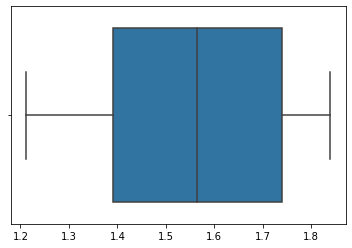

In [35]:
#distribution of the predicted variable
g1 = sns.boxplot(x=y_pred)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


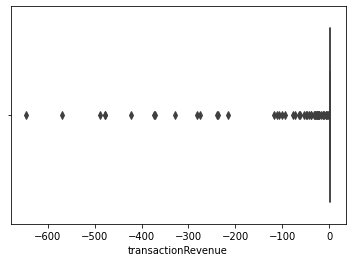

In [36]:
##distribution of the erro

erro = (y_pred - y_test )
g2=sns.boxplot(erro)

* this model is not predicting good results

# Second Model 

---

Na primeira tentativa de modelo, levamos em consideração apenas as variavais quantitativas. agora vamos também usar algumas variaveis qualitativas como o numero de visitas, o aparelho no qual acessou o site, o jeito que ficou sabendo do site entre outras. 


para isso iremos criar um novo grupo de varieaveis.

---

In the first model attempt, we only considered the quantitative variables. now we are also going to use some qualitative variables such as the number of visits, the device on which you accessed the site, the way you learned about the site, among others.


for this we will create a new group of variables.

In [37]:
last_visit = df.groupby('fullVisitorId', as_index = False)['visitNumber'].max()
last_visit

,fullVisitorId,visitNumber
0,0002365800130207040,1
1,0010286039787739137,1
2,0011056874471185769,1
3,0014443856125569702,1
4,0017260116665815114,6
...,...,...
9992,9996691020299725061,3
9993,9996793353803109760,1
9994,9997125062030599880,1
9995,9997464307347866920,1


In [38]:
df_not_duplicate = df.drop_duplicates(subset = ['visitNumber','fullVisitorId'])
df_not_duplicate

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,browser,operatingSystem,isMobile,...,keyword,isTrueDirect,referralPath,adContent,campaignCode,hits,pageviews,bounces,newVisits,transactionRevenue
0,Organic Search,20160902,9674781571160116268,9674781571160116268_1472804607,1472804607,1,1472804607,Chrome,Windows,False,...,(not provided),NaN,NaN,NaN,NaN,1,1,1.0,1.0,0.0
1,Organic Search,20160902,8590648239310839049,8590648239310839049_1472835928,1472835928,1,1472835928,Chrome,Macintosh,False,...,(not provided),NaN,NaN,NaN,NaN,1,1,1.0,1.0,0.0
2,Affiliates,20160902,9772828344252850532,9772828344252850532_1472856802,1472856802,1,1472856802,Chrome,Macintosh,False,...,NaN,NaN,NaN,NaN,NaN,1,1,1.0,1.0,0.0
3,Organic Search,20160902,1350700416054916432,1350700416054916432_1472879649,1472879649,2,1472879649,Safari,iOS,True,...,(not provided),True,NaN,NaN,NaN,1,1,1.0,NaN,0.0
4,Organic Search,20160902,1350700416054916432,1350700416054916432_1472829671,1472829671,1,1472829671,Safari,iOS,True,...,(not provided),NaN,NaN,NaN,NaN,5,4,NaN,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12278,Social,20170104,7330357551242339916,7330357551242339916_1483540608,1483540608,1,1483540608,Chrome,Windows,False,...,NaN,NaN,/yt/about/pl/,NaN,NaN,1,1,1.0,1.0,0.0
12279,Social,20170104,696320405243257438,0696320405243257438_1483580407,1483580407,1,1483580407,Chrome,Android,True,...,NaN,NaN,/yt/about/,NaN,NaN,1,1,1.0,1.0,0.0
12280,Social,20170104,5437703324867866371,5437703324867866371_1483592122,1483592122,1,1483592122,Chrome,Linux,False,...,NaN,NaN,/yt/about/,NaN,NaN,1,1,1.0,1.0,0.0
12281,Social,20170104,8869363093179043393,8869363093179043393_1483601927,1483601927,2,1483601927,Chrome,Android,True,...,NaN,True,/yt/about/lt/,NaN,NaN,2,2,NaN,NaN,0.0


In [39]:
df_not_duplicate.shape

(12270, 31)

In [40]:
df_visit = pd.merge(last_visit,df_not_duplicate,left_on=['visitNumber','fullVisitorId'],right_on = ['visitNumber','fullVisitorId'], how='left')
df_visit

,fullVisitorId,visitNumber,channelGrouping,date,sessionId,visitId,visitStartTime,browser,operatingSystem,isMobile,...,keyword,isTrueDirect,referralPath,adContent,campaignCode,hits,pageviews,bounces,newVisits,transactionRevenue
0,0002365800130207040,1,Social,20160904,0002365800130207040_1472974804,1472974804,1472974804,Edge,Windows,False,...,NaN,NaN,/yt/about/ru/,NaN,NaN,1,1,1.0,1.0,0.0
1,0010286039787739137,1,Organic Search,20160928,0010286039787739137_1475084026,1475084026,1475084026,Chrome,Chrome OS,False,...,(not provided),NaN,NaN,NaN,NaN,4,3,NaN,1.0,0.0
2,0011056874471185769,1,Social,20161205,0011056874471185769_1480996024,1480996024,1480996024,Chrome,Windows,False,...,NaN,NaN,/yt/about/,NaN,NaN,2,2,NaN,1.0,0.0
3,0014443856125569702,1,Social,20161002,0014443856125569702_1475423502,1475423502,1475423502,Opera,Windows,False,...,NaN,NaN,/yt/about/ro/,NaN,NaN,1,1,1.0,1.0,0.0
4,0017260116665815114,6,Direct,20170420,0017260116665815114_1492707286,1492707286,1492707286,Safari,Macintosh,False,...,NaN,True,NaN,NaN,NaN,2,2,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9992,9996691020299725061,3,Referral,20161221,9996691020299725061_1482388264,1482388264,1482388264,Chrome,Macintosh,False,...,NaN,True,/,NaN,NaN,10,10,NaN,NaN,0.0
9993,9996793353803109760,1,Social,20161130,9996793353803109760_1480566609,1480566609,1480566609,Chrome,Android,True,...,NaN,NaN,/yt/about/th/,NaN,NaN,1,1,1.0,1.0,0.0
9994,9997125062030599880,1,Organic Search,20170112,9997125062030599880_1484217422,1484217422,1484217422,Safari,iOS,True,...,(not provided),NaN,NaN,NaN,NaN,8,8,NaN,1.0,0.0
9995,9997464307347866920,1,Organic Search,20170314,9997464307347866920_1489504370,1489504370,1489504370,Chrome,Android,True,...,(not provided),NaN,NaN,NaN,NaN,1,1,1.0,1.0,0.0


In [41]:
first_visit = df.groupby('fullVisitorId', as_index = False)['visitNumber'].min()
first_visit

,fullVisitorId,visitNumber
0,0002365800130207040,1
1,0010286039787739137,1
2,0011056874471185769,1
3,0014443856125569702,1
4,0017260116665815114,6
...,...,...
9992,9996691020299725061,3
9993,9996793353803109760,1
9994,9997125062030599880,1
9995,9997464307347866920,1


In [42]:
first_visit.set_index('fullVisitorId',inplace=True)
first_visit.head()

,visitNumber
fullVisitorId,
0002365800130207040,1
0010286039787739137,1
0011056874471185769,1
0014443856125569702,1
0017260116665815114,6


In [43]:
df_visit = df_visit.join(first_visit, how = 'left', on = 'fullVisitorId', rsuffix = '_first')
df_visit.columns

Index(['fullVisitorId', 'visitNumber', 'channelGrouping', 'date', 'sessionId',
       'visitId', 'visitStartTime', 'browser', 'operatingSystem', 'isMobile',
       'deviceCategory', 'continent', 'subContinent', 'country', 'region',
       'metro', 'city', 'networkDomain', 'campaign', 'source', 'medium',
       'keyword', 'isTrueDirect', 'referralPath', 'adContent', 'campaignCode',
       'hits', 'pageviews', 'bounces', 'newVisits', 'transactionRevenue',
       'visitNumber_first'],
      dtype='object')

In [44]:
df_visit = pd.merge(df_visit,df_not_duplicate,left_on=['visitNumber','fullVisitorId'],right_on = ['visitNumber','fullVisitorId'], how='left', suffixes=['_last','_first'])
df_visit.columns

Index(['fullVisitorId', 'visitNumber', 'channelGrouping_last', 'date_last',
       'sessionId_last', 'visitId_last', 'visitStartTime_last', 'browser_last',
       'operatingSystem_last', 'isMobile_last', 'deviceCategory_last',
       'continent_last', 'subContinent_last', 'country_last', 'region_last',
       'metro_last', 'city_last', 'networkDomain_last', 'campaign_last',
       'source_last', 'medium_last', 'keyword_last', 'isTrueDirect_last',
       'referralPath_last', 'adContent_last', 'campaignCode_last', 'hits_last',
       'pageviews_last', 'bounces_last', 'newVisits_last',
       'transactionRevenue_last', 'visitNumber_first', 'channelGrouping_first',
       'date_first', 'sessionId_first', 'visitId_first',
       'visitStartTime_first', 'browser_first', 'operatingSystem_first',
       'isMobile_first', 'deviceCategory_first', 'continent_first',
       'subContinent_first', 'country_first', 'region_first', 'metro_first',
       'city_first', 'networkDomain_first', 'campaign_f

In [45]:
for coluna in quant:
  df_visit.drop(coluna + '_first', axis=1, inplace=True)
  df_visit.drop(coluna + '_last', axis=1, inplace =True)

df_visit.columns

Index(['fullVisitorId', 'visitNumber', 'channelGrouping_last', 'date_last',
       'sessionId_last', 'visitId_last', 'visitStartTime_last', 'browser_last',
       'operatingSystem_last', 'isMobile_last', 'deviceCategory_last',
       'continent_last', 'subContinent_last', 'country_last', 'region_last',
       'metro_last', 'city_last', 'networkDomain_last', 'campaign_last',
       'source_last', 'medium_last', 'keyword_last', 'isTrueDirect_last',
       'referralPath_last', 'adContent_last', 'campaignCode_last',
       'visitNumber_first', 'channelGrouping_first', 'date_first',
       'sessionId_first', 'visitId_first', 'visitStartTime_first',
       'browser_first', 'operatingSystem_first', 'isMobile_first',
       'deviceCategory_first', 'continent_first', 'subContinent_first',
       'country_first', 'region_first', 'metro_first', 'city_first',
       'networkDomain_first', 'campaign_first', 'source_first', 'medium_first',
       'keyword_first', 'isTrueDirect_first', 'referralPath_

In [46]:
#  removing the columns with id because they are just identifiers 

id = ['sessionId_last','visitId_last','sessionId_first','visitId_first']

df_visit.drop(id,axis=1,inplace=True)

df_visit.columns

Index(['fullVisitorId', 'visitNumber', 'channelGrouping_last', 'date_last',
       'visitStartTime_last', 'browser_last', 'operatingSystem_last',
       'isMobile_last', 'deviceCategory_last', 'continent_last',
       'subContinent_last', 'country_last', 'region_last', 'metro_last',
       'city_last', 'networkDomain_last', 'campaign_last', 'source_last',
       'medium_last', 'keyword_last', 'isTrueDirect_last', 'referralPath_last',
       'adContent_last', 'campaignCode_last', 'visitNumber_first',
       'channelGrouping_first', 'date_first', 'visitStartTime_first',
       'browser_first', 'operatingSystem_first', 'isMobile_first',
       'deviceCategory_first', 'continent_first', 'subContinent_first',
       'country_first', 'region_first', 'metro_first', 'city_first',
       'networkDomain_first', 'campaign_first', 'source_first', 'medium_first',
       'keyword_first', 'isTrueDirect_first', 'referralPath_first',
       'adContent_first', 'campaignCode_first'],
      dtype='object'

In [47]:
# leaving only the last location of the visitor. 

df_visit.drop(['city_first','country_first','metro_first','continent_first', 'region_first',
                'networkDomain_first','subContinent_first'],axis=1,inplace=True)

df_visit.columns

Index(['fullVisitorId', 'visitNumber', 'channelGrouping_last', 'date_last',
       'visitStartTime_last', 'browser_last', 'operatingSystem_last',
       'isMobile_last', 'deviceCategory_last', 'continent_last',
       'subContinent_last', 'country_last', 'region_last', 'metro_last',
       'city_last', 'networkDomain_last', 'campaign_last', 'source_last',
       'medium_last', 'keyword_last', 'isTrueDirect_last', 'referralPath_last',
       'adContent_last', 'campaignCode_last', 'visitNumber_first',
       'channelGrouping_first', 'date_first', 'visitStartTime_first',
       'browser_first', 'operatingSystem_first', 'isMobile_first',
       'deviceCategory_first', 'campaign_first', 'source_first',
       'medium_first', 'keyword_first', 'isTrueDirect_first',
       'referralPath_first', 'adContent_first', 'campaignCode_first'],
      dtype='object')

In [48]:
df_visit.columns.shape

(40,)

In [49]:
df_visit = pd.merge(df_visit,df_quant,left_on=['fullVisitorId'],right_on = ['fullVisitorId'], how='left')
df_visit

,fullVisitorId,visitNumber,channelGrouping_last,date_last,visitStartTime_last,browser_last,operatingSystem_last,isMobile_last,deviceCategory_last,continent_last,...,keyword_first,isTrueDirect_first,referralPath_first,adContent_first,campaignCode_first,bounces,hits,newVisits,pageviews,transactionRevenue
0,0002365800130207040,1,Social,20160904,1472974804,Edge,Windows,False,desktop,Europe,...,NaN,NaN,/yt/about/ru/,NaN,NaN,1.0,1,1.0,1,0.0
1,0010286039787739137,1,Organic Search,20160928,1475084026,Chrome,Chrome OS,False,desktop,Americas,...,(not provided),NaN,NaN,NaN,NaN,0.0,4,1.0,3,0.0
2,0011056874471185769,1,Social,20161205,1480996024,Chrome,Windows,False,desktop,Asia,...,NaN,NaN,/yt/about/,NaN,NaN,0.0,2,1.0,2,0.0
3,0014443856125569702,1,Social,20161002,1475423502,Opera,Windows,False,desktop,Europe,...,NaN,NaN,/yt/about/ro/,NaN,NaN,1.0,1,1.0,1,0.0
4,0017260116665815114,6,Direct,20170420,1492707286,Safari,Macintosh,False,desktop,Americas,...,NaN,True,NaN,NaN,NaN,0.0,2,0.0,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9992,9996691020299725061,3,Referral,20161221,1482388264,Chrome,Macintosh,False,desktop,Americas,...,NaN,True,/,NaN,NaN,0.0,10,0.0,10,0.0
9993,9996793353803109760,1,Social,20161130,1480566609,Chrome,Android,True,mobile,Asia,...,NaN,NaN,/yt/about/th/,NaN,NaN,1.0,1,1.0,1,0.0
9994,9997125062030599880,1,Organic Search,20170112,1484217422,Safari,iOS,True,mobile,Americas,...,(not provided),NaN,NaN,NaN,NaN,0.0,8,1.0,8,0.0
9995,9997464307347866920,1,Organic Search,20170314,1489504370,Chrome,Android,True,mobile,Europe,...,(not provided),NaN,NaN,NaN,NaN,1.0,1,1.0,1,0.0


In [50]:
#calculating time difference between the user's first and last visit

df_visit['dif_time'] = df_visit['visitStartTime_last'] - df_visit['visitStartTime_first']
df_visit

,fullVisitorId,visitNumber,channelGrouping_last,date_last,visitStartTime_last,browser_last,operatingSystem_last,isMobile_last,deviceCategory_last,continent_last,...,isTrueDirect_first,referralPath_first,adContent_first,campaignCode_first,bounces,hits,newVisits,pageviews,transactionRevenue,dif_time
0,0002365800130207040,1,Social,20160904,1472974804,Edge,Windows,False,desktop,Europe,...,NaN,/yt/about/ru/,NaN,NaN,1.0,1,1.0,1,0.0,0
1,0010286039787739137,1,Organic Search,20160928,1475084026,Chrome,Chrome OS,False,desktop,Americas,...,NaN,NaN,NaN,NaN,0.0,4,1.0,3,0.0,0
2,0011056874471185769,1,Social,20161205,1480996024,Chrome,Windows,False,desktop,Asia,...,NaN,/yt/about/,NaN,NaN,0.0,2,1.0,2,0.0,0
3,0014443856125569702,1,Social,20161002,1475423502,Opera,Windows,False,desktop,Europe,...,NaN,/yt/about/ro/,NaN,NaN,1.0,1,1.0,1,0.0,0
4,0017260116665815114,6,Direct,20170420,1492707286,Safari,Macintosh,False,desktop,Americas,...,True,NaN,NaN,NaN,0.0,2,0.0,2,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9992,9996691020299725061,3,Referral,20161221,1482388264,Chrome,Macintosh,False,desktop,Americas,...,True,/,NaN,NaN,0.0,10,0.0,10,0.0,0
9993,9996793353803109760,1,Social,20161130,1480566609,Chrome,Android,True,mobile,Asia,...,NaN,/yt/about/th/,NaN,NaN,1.0,1,1.0,1,0.0,0
9994,9997125062030599880,1,Organic Search,20170112,1484217422,Safari,iOS,True,mobile,Americas,...,NaN,NaN,NaN,NaN,0.0,8,1.0,8,0.0,0
9995,9997464307347866920,1,Organic Search,20170314,1489504370,Chrome,Android,True,mobile,Europe,...,NaN,NaN,NaN,NaN,1.0,1,1.0,1,0.0,0


In [51]:
# calculating the total number of user accesses

total_visit = df.groupby('fullVisitorId', as_index = False).count()['visitNumber'].values
total_visit

array([1, 1, 1, ..., 1, 1, 2])

In [52]:
df_visit['total_visit'] = total_visit
df_visit

,fullVisitorId,visitNumber,channelGrouping_last,date_last,visitStartTime_last,browser_last,operatingSystem_last,isMobile_last,deviceCategory_last,continent_last,...,referralPath_first,adContent_first,campaignCode_first,bounces,hits,newVisits,pageviews,transactionRevenue,dif_time,total_visit
0,0002365800130207040,1,Social,20160904,1472974804,Edge,Windows,False,desktop,Europe,...,/yt/about/ru/,NaN,NaN,1.0,1,1.0,1,0.0,0,1
1,0010286039787739137,1,Organic Search,20160928,1475084026,Chrome,Chrome OS,False,desktop,Americas,...,NaN,NaN,NaN,0.0,4,1.0,3,0.0,0,1
2,0011056874471185769,1,Social,20161205,1480996024,Chrome,Windows,False,desktop,Asia,...,/yt/about/,NaN,NaN,0.0,2,1.0,2,0.0,0,1
3,0014443856125569702,1,Social,20161002,1475423502,Opera,Windows,False,desktop,Europe,...,/yt/about/ro/,NaN,NaN,1.0,1,1.0,1,0.0,0,1
4,0017260116665815114,6,Direct,20170420,1492707286,Safari,Macintosh,False,desktop,Americas,...,NaN,NaN,NaN,0.0,2,0.0,2,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9992,9996691020299725061,3,Referral,20161221,1482388264,Chrome,Macintosh,False,desktop,Americas,...,/,NaN,NaN,0.0,10,0.0,10,0.0,0,1
9993,9996793353803109760,1,Social,20161130,1480566609,Chrome,Android,True,mobile,Asia,...,/yt/about/th/,NaN,NaN,1.0,1,1.0,1,0.0,0,1
9994,9997125062030599880,1,Organic Search,20170112,1484217422,Safari,iOS,True,mobile,Americas,...,NaN,NaN,NaN,0.0,8,1.0,8,0.0,0,1
9995,9997464307347866920,1,Organic Search,20170314,1489504370,Chrome,Android,True,mobile,Europe,...,NaN,NaN,NaN,1.0,1,1.0,1,0.0,0,1


In [53]:
df_visit['year_last'] = pd.to_numeric([data[0:4] for data in df_visit.date_last])
df_visit['month_last'] = pd.to_numeric([data[4:6] for data in df_visit.date_last])
df_visit['day_last'] = pd.to_numeric([data[6:8] for data in df_visit.date_last])

df_visit['year_first'] = pd.to_numeric([data[0:4] for data in df_visit.date_first])
df_visit['month_first'] = pd.to_numeric([data[4:6] for data in df_visit.date_first])
df_visit['day_first'] = pd.to_numeric([data[6:8] for data in df_visit.date_first])

df_visit.dtypes

fullVisitorId             object
visitNumber                int64
channelGrouping_last      object
date_last                 object
visitStartTime_last        int64
browser_last              object
operatingSystem_last      object
isMobile_last               bool
deviceCategory_last       object
continent_last            object
subContinent_last         object
country_last              object
region_last               object
metro_last                object
city_last                 object
networkDomain_last        object
campaign_last             object
source_last               object
medium_last               object
keyword_last              object
isTrueDirect_last         object
referralPath_last         object
adContent_last            object
campaignCode_last         object
visitNumber_first          int64
channelGrouping_first     object
date_first                object
visitStartTime_first       int64
browser_first             object
operatingSystem_first     object
isMobile_f

In [54]:
df_visit.drop('fullVisitorId', axis=1, inplace=True)

In [55]:
df_visit

,visitNumber,channelGrouping_last,date_last,visitStartTime_last,browser_last,operatingSystem_last,isMobile_last,deviceCategory_last,continent_last,subContinent_last,...,pageviews,transactionRevenue,dif_time,total_visit,year_last,month_last,day_last,year_first,month_first,day_first
0,1,Social,20160904,1472974804,Edge,Windows,False,desktop,Europe,Eastern Europe,...,1,0.0,0,1,2016,9,4,2016,9,4
1,1,Organic Search,20160928,1475084026,Chrome,Chrome OS,False,desktop,Americas,Northern America,...,3,0.0,0,1,2016,9,28,2016,9,28
2,1,Social,20161205,1480996024,Chrome,Windows,False,desktop,Asia,Southeast Asia,...,2,0.0,0,1,2016,12,5,2016,12,5
3,1,Social,20161002,1475423502,Opera,Windows,False,desktop,Europe,Eastern Europe,...,1,0.0,0,1,2016,10,2,2016,10,2
4,6,Direct,20170420,1492707286,Safari,Macintosh,False,desktop,Americas,Northern America,...,2,0.0,0,1,2017,4,20,2017,4,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9992,3,Referral,20161221,1482388264,Chrome,Macintosh,False,desktop,Americas,Northern America,...,10,0.0,0,1,2016,12,21,2016,12,21
9993,1,Social,20161130,1480566609,Chrome,Android,True,mobile,Asia,Southeast Asia,...,1,0.0,0,1,2016,11,30,2016,11,30
9994,1,Organic Search,20170112,1484217422,Safari,iOS,True,mobile,Americas,Northern America,...,8,0.0,0,1,2017,1,12,2017,1,12
9995,1,Organic Search,20170314,1489504370,Chrome,Android,True,mobile,Europe,Southern Europe,...,1,0.0,0,1,2017,3,14,2017,3,14


# Starting the second regression mode

---

In [56]:
y = df_visit['transactionRevenue'].copy()

x = df_visit.drop('transactionRevenue', axis = 1)

In [57]:
# converting the qualitative variables of the dataset into numbers

quali = df_visit.dtypes[df_visit.dtypes.values == object].keys()
quali

Index(['channelGrouping_last', 'date_last', 'browser_last',
       'operatingSystem_last', 'deviceCategory_last', 'continent_last',
       'subContinent_last', 'country_last', 'region_last', 'metro_last',
       'city_last', 'networkDomain_last', 'campaign_last', 'source_last',
       'medium_last', 'keyword_last', 'isTrueDirect_last', 'referralPath_last',
       'adContent_last', 'campaignCode_last', 'channelGrouping_first',
       'date_first', 'browser_first', 'operatingSystem_first',
       'deviceCategory_first', 'campaign_first', 'source_first',
       'medium_first', 'keyword_first', 'isTrueDirect_first',
       'referralPath_first', 'adContent_first', 'campaignCode_first'],
      dtype='object')

In [58]:
lbl = LabelEncoder()

for coluna in quali:
  string = list(x[coluna].values.astype('str'))
  lbl.fit(string)
  x[coluna] = lbl.transform(string)

In [59]:
x.head()

,visitNumber,channelGrouping_last,date_last,visitStartTime_last,browser_last,operatingSystem_last,isMobile_last,deviceCategory_last,continent_last,subContinent_last,...,newVisits,pageviews,dif_time,total_visit,year_last,month_last,day_last,year_first,month_first,day_first
0,1,7,34,1472974804,7,9,False,0,4,7,...,1.0,1,0,1,2016,9,4,2016,9,4
1,1,4,58,1475084026,5,3,False,0,2,11,...,1.0,3,0,1,2016,9,28,2016,9,28
2,1,7,126,1480996024,5,9,False,0,3,15,...,1.0,2,0,1,2016,12,5,2016,12,5
3,1,7,62,1475423502,15,9,False,0,4,7,...,1.0,1,0,1,2016,10,2,2016,10,2
4,6,2,262,1492707286,18,6,False,0,2,11,...,0.0,2,0,1,2017,4,20,2017,4,20


In [60]:
#separating training and testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = SEED )

# training and tuning the model
lr = LinearRegression()
lr = lr.fit(x_train,y_train)
y_pred_lr = lr.predict(x_test)
y_pred_lr[y_pred_lr < 0 ] = 0 # normally there are no negative values ​​in an ecommerce


# caculating MSE e RMSE
print('MSE : {:.4f}'.format(mean_squared_error(y_test,y_pred_lr)))
print('RMSE : {:.4f}'.format( np.sqrt( mean_squared_error( y_test,y_pred_lr) ) ) )

MSE : 617.6714
RMSE : 24.8530


# Third model - Gradient Boosting

In [61]:
# training and tuning the model

gb = GradientBoostingRegressor(random_state=SEED)
gb.fit(x_train,y_train)

y_pred_gb = gb.predict(x_test)

y_pred_gb[y_pred_gb < 0] = 0

# caculating MSE e RMSE
print('MSE : {:.4f}'.format(mean_squared_error(y_test,y_pred_gb)))
print('RMSE : {:.4f}'.format( np.sqrt( mean_squared_error( y_test,y_pred_gb) ) ) )
print('MAE: {:.4f}' .format( mean_absolute_error(y_test,y_pred_gb)))

MSE : 642.3646
RMSE : 25.3449
MAE: 3.0807


In [62]:
# optimizing the parameters

n_estimators = np.arange(20,100,step=20)
#subsample = [0.2, 0.4, 0.6, 0.8, 1.0]
#criterion = ['friedman_mse', 'squared_error', 'mse']
min_sample_leaf = [1,2,4]
#min_sample_split = np.arange(2,10,step=2)
max_depth = list(np.arange(2,4,step=1))
#max_features = ['auto', 'sqrt', 'log2']

params_grid = {
    'n_estimators':n_estimators,
    #'criterion':criterion,
    #'max_features':max_features,
    'max_depth':max_depth,
    #'min_samples_split': min_sample_split,
    'min_samples_leaf': min_sample_leaf,
    #'subsample':subsample
}


gb = GradientBoostingRegressor(subsample = 0.2, random_state=SEED)

grid_cv = GridSearchCV(gb, params_grid,cv=3, scoring = 'neg_mean_absolute_error', n_jobs = -1)

ggb = grid_cv.fit(x_train,y_train)

y_pred_ggb = ggb.predict(x_test)

y_pred_ggb[y_pred_ggb < 0] = 0

# caculating MSE e RMSE
print('MSE : {:.4f}'.format(mean_squared_error(y_test,y_pred_ggb)))
print('RMSE : {:.4f}'.format( np.sqrt( mean_squared_error( y_test,y_pred_ggb) ) ) )
print('MAE: {:.4f}' .format( mean_absolute_error(y_test,y_pred_ggb)))

MSE : 578.0392
RMSE : 24.0424
MAE: 2.9951


# XGBoosting Model

In [63]:
#!pip install xgboost

In [64]:
from xgboost import XGBRegressor

In [65]:
x_train.drop_duplicates()

xgb = XGBRegressor(objective ='reg:linear', random_state = SEED)
xgb.fit(x_train,y_train)

y_pred_xgb = xgb.predict(x_test)

y_pred_xgb[y_pred_xgb < 0] = 0

# caculating MSE e RMSE
print('MSE : {:.4f}'.format(mean_squared_error(y_test,y_pred_xgb)))
print('RMSE : {:.4f}'.format( np.sqrt( mean_squared_error( y_test,y_pred_xgb) ) ) )

[13:01:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE : 622.8260
RMSE : 24.9565


# Comparing results

---



In [67]:
results = pd.DataFrame(y_test)
results

,transactionRevenue
4122,0.0
4065,0.0
1731,0.0
4740,0.0
6391,0.0
...,...
5580,0.0
1074,0.0
3063,0.0
4554,0.0


In [73]:
result['results_quant'] = y_pred
result['results_lr'] = y_pred_lr
result['results_Gridgb'] = y_pred_ggb
result['results_XGB'] = y_pred_xgb

result[result['transactionRevenue']>0]

,transactionRevenue,results_quant,results_lr,results_Gridgb,results_XGB
3006,32.49,1.616211,15.079345,7.897669,28.690338
5928,74.85,1.449755,36.595509,5.642668,3.019218
8361,424.50,1.306194,19.734006,13.644768,28.011162
8612,55.99,1.291322,15.495067,9.848903,22.238096
416,15.19,1.831725,23.793319,7.726109,16.170380
4077,5.97,1.554336,15.537039,10.447674,14.800636
8146,27.19,1.318915,18.056811,11.870855,28.272476
4908,372.65,1.505642,135.873577,100.808902,22.141327
9395,29.98,1.779852,19.759874,9.748061,19.591881
8728,101.95,1.284318,85.532026,165.906174,164.794769
